In [50]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from cgtasknet.instruments.instrument_subgroups import SubgroupFinder

from norse.torch.functional.lif_adex import LIFAdExParameters
from norse.torch.functional.lif_adex_refrac import LIFAdExRefracParameters

from tqdm import tqdm
from cgtasknet.net.lifadexrefrac import SNNlifadexrefrac
from cgtasknet.instruments.instrument_pca import PCA

from cgtasknet.net.states import LIFAdExRefracInitState
from cgtasknet.tasks.reduce import (
    DMTaskParameters,
    DMTask,
    RomoTask,
    RomoTaskParameters,
)

from cgtasknet.instruments.instrument_subgroups import sort_elemnts_by_another

In [51]:
plt.style.use("ggplot")


def plot_hist(data, c="#003153", alpha=1, label=""):
    x = np.arange(0, len(data), 1)
    for i in range(len(data)):
        if i == 0:
            plt.plot(
                [x[i]] * 2, [0, data[i]], c=c, alpha=alpha, linewidth=0.5, label=label
            )
        else:
            plt.plot([x[i]] * 2, [0, data[i]], c=c, alpha=alpha, linewidth=0.5)

# Генерация задач
Генерируем параметры для Romo задачи DM задачи и генерируем сами задачи с одним батчем в каждом датасете

In [52]:
romoparams = RomoTaskParameters(
    delay=0.1,
    positive_shift_delay_time=0.5,
    trial_time=0.1,
    positive_shift_trial_time=0.2,
)
dmparams = DMTaskParameters(trial_time=0.1, positive_shift_trial_time=0.8)
romo_task = RomoTask(romoparams)
dm_task = DMTask(dmparams)

# Загрузка сети
Необходимо загрузить разбросанный параметр ```tau_ada_inv``` через ```np.load```. Далее необходимо создать инициализированную сеть и загрузить сохраненные веса в нее.

In [53]:
dt = 1e-3
feature_size = 4
output_size = 3
hidden_size = 450
batch_size = 1
tau_ada_inv_distrib = np.load(
    "..\\..\\..\\models\\dm_and_romo\\lif_adex_refrac\\dm_and_romo_reduce_adex_refrac_450_95_percents_2000_epochs_alpha=100.npy"
)
neuron_parameters = LIFAdExRefracParameters(
    LIFAdExParameters(
        v_th=torch.as_tensor(0.65),
        tau_ada_inv=torch.from_numpy(tau_ada_inv_distrib),
        alpha=100,
        method="super",
    ),
    rho_reset=torch.as_tensor(1),
)
model = SNNlifadexrefrac(
    feature_size,
    hidden_size,
    output_size,
    neuron_parameters=neuron_parameters,
    tau_filter_inv=500,
    save_states=True,
)
if True:
    model.load_state_dict(
        torch.load(
            "..\\..\\..\\models\\dm_and_romo\\lif_adex_refrac\\dm_and_romo_reduce_adex_refrac_450_95_percents_2000_epochs_alpha=100"
        )
    )

number_of_tasks = 1000  # Количество задач, которые используются для усреднения частот

# DM задача
## Дополнение входных данных до нужной размерности
Необходимо дополнить исходные данные дополнительными двумя размерностями по последней оси. Причем необходимо заполнить первую единицами, т.е. мы создаем на каждой итерации матрицу следующего вида.
```
RuleDMTaskMatr = np.zeros((inputs.shape[0], inputs.shape[1], 2))
RuleDMTaskMatr[:, :, 0] = 1
```
## Выделение подгрупп
### Сохранение состояний
Просто сохраняем состояния во время испытания в виде последовательности спайков, которые потом можно использовать для того, чтобы вычислять среднее количество частот.
### Выделение частот
Используем ```SubgroupFinder```, чтобы получить средние частоты во время всего испытания, данный инструмент также проверяет корректность данной задачи. 


# DM

In [54]:
# DM task
dm_subgroup_finder = SubgroupFinder(dt)
for i in tqdm(range(number_of_tasks)):
    inputs, t_outputs = dm_task.dataset(1)  # Генерация одного испытания
    rule_matrix = np.zeros(
        (inputs.shape[0], 1, 2)
    )  # (time steps, batch size, number of tasks
    rule_matrix[:, :, 0] = 1  # Обозначение для сети того, что это DM
    inputs = np.concatenate((inputs, rule_matrix), axis=2)
    inputs = torch.from_numpy(inputs).type(torch.float32)
    t_outputs = torch.from_numpy(t_outputs).type(torch.float32)
    dm_out, dm_states = model(inputs)
    s = []
    for j in range(len(dm_states)):
        s.append(dm_states[j].lif_adex.z)
    s = torch.stack(s).detach()
    if len(s.shape) == 3:
        s = s.reshape((s.shape[0], s.shape[2]))
    dm_subgroup_finder.compute_average_freq(
        [s], [inputs[:, 0, 0]], [dm_out], [t_outputs]
    )
    dm_fixation, dm_answer = dm_subgroup_finder.get_average_freq()

100%|██████████| 1000/1000 [05:48<00:00,  2.87it/s]


# Romo

In [55]:
romo_subgroup_finder = SubgroupFinder(dt)
for i in tqdm(range(number_of_tasks)):
    inputs, t_outputs = romo_task.dataset(1)
    rule_matrix = np.zeros((inputs.shape[0], 1, 2))
    rule_matrix[:, :, 1] = 1  # Обозначение для сети, что сейчас romo задача
    inputs = np.concatenate((inputs, rule_matrix), axis=2)
    inputs = torch.from_numpy(inputs).type(torch.float32)
    t_outputs = torch.from_numpy(t_outputs).type(torch.float32)
    romo_out, romo_states = model(inputs)
    s = []
    for j in range(len(romo_states)):
        s.append(romo_states[j].lif_adex.z)
    s = torch.stack(s).detach()
    if len(s.shape) == 3:
        s = s.reshape((s.shape[0], s.shape[2]))
    romo_subgroup_finder.compute_average_freq(
        [s], [inputs[:, 0, 0]], [romo_out], [t_outputs]
    )
    romo_fixation, romo_answer = romo_subgroup_finder.get_average_freq()

100%|██████████| 1000/1000 [08:01<00:00,  2.07it/s]


# Сортировка элементов по частотам

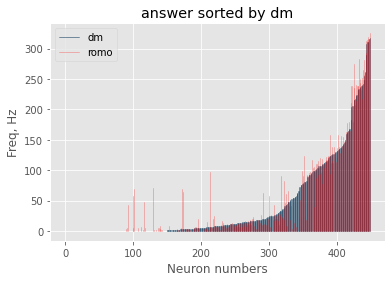

In [56]:
dm_answer_sort = sort_elemnts_by_another(dm_answer, dm_answer)
romo_answer_sort_by_dm = sort_elemnts_by_another(dm_answer, romo_answer)
plot_hist(dm_answer_sort, label="dm")
plot_hist(romo_answer_sort_by_dm, c="r", alpha=0.5, label="romo")
plt.xlabel("Neuron numbers")
plt.ylabel("Freq, Hz")
plt.title("answer sorted by dm")
plt.legend()
plt.show()
plt.close()

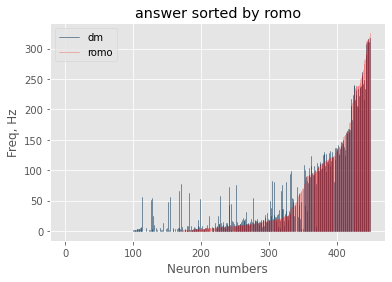

In [57]:
romo_answer_sort = sort_elemnts_by_another(romo_answer, romo_answer)
dm_answer_sort_by_romo = sort_elemnts_by_another(romo_answer, dm_answer)
plot_hist(dm_answer_sort_by_romo, label="dm")
plot_hist(romo_answer_sort, c="r", alpha=0.5, label="romo")
plt.xlabel("Neuron numbers")
plt.ylabel("Freq, Hz")
plt.title("answer sorted by romo")
plt.legend()
plt.show()
plt.close()

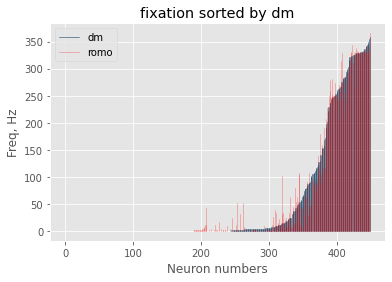

In [58]:
dm_fixation_sort = sort_elemnts_by_another(dm_fixation, dm_fixation)
romo_fixation_sort_by_dm = sort_elemnts_by_another(dm_fixation, romo_fixation)
plot_hist(dm_fixation_sort, label="dm")
plot_hist(romo_fixation_sort_by_dm, c="r", alpha=0.5, label="romo")
plt.xlabel("Neuron numbers")
plt.ylabel("Freq, Hz")
plt.title("fixation sorted by dm")
plt.legend()
plt.show()
plt.close()

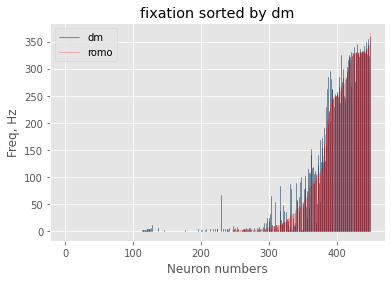

In [59]:
dm_fixation_sort_by_romo_fixation = sort_elemnts_by_another(romo_fixation, dm_fixation)
romo_fixation_sort = sort_elemnts_by_another(romo_fixation, romo_fixation)
plot_hist(dm_fixation_sort_by_romo_fixation, label="dm")
plot_hist(romo_fixation_sort, c="r", alpha=0.5, label="romo")
plt.xlabel("Neuron numbers")
plt.ylabel("Freq, Hz")
plt.title("fixation sorted by dm")
plt.legend()
plt.show()
plt.close()

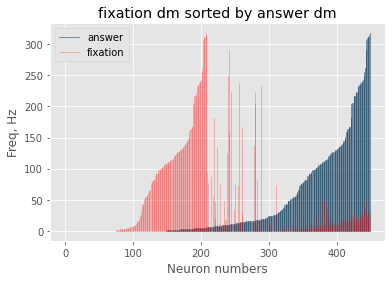

In [60]:
dm_fixation_sort_by_dm_answer = sort_elemnts_by_another(dm_fixation, dm_answer)
plot_hist(dm_answer_sort, label="answer")
plot_hist(dm_fixation_sort_by_dm_answer, c="r", alpha=0.5, label="fixation")
plt.xlabel("Neuron numbers")
plt.ylabel("Freq, Hz")
plt.title("fixation dm sorted by answer dm")
plt.legend()
plt.show()
plt.close()

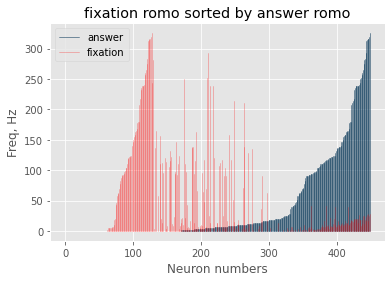

In [61]:
romo_fixation_sort_by_romo_answer = sort_elemnts_by_another(romo_fixation, romo_answer)
plot_hist(romo_answer_sort, label="answer")
plot_hist(romo_fixation_sort_by_romo_answer, c="r", alpha=0.5, label="fixation")
plt.xlabel("Neuron numbers")
plt.ylabel("Freq, Hz")
plt.title("fixation romo sorted by answer romo")
plt.legend()
plt.show()
plt.close()